# AA/EE/ME 548: Homework 04

## Name: Yenpang Huang

### Export page instructions:
Make sure all the text and figures are shown in your PDF print out. Try zooming out / widening your browser window etc when you print to PDF. Whatever needs to be done so that all the relevant content is shown in the PDF.

### Homework feedback:

**What was the coolest thing(s) you learned from lectures/homework that you didn't know previously?**


**Which problem did you find the most challenging and why?**
2

**Approximate how long did you spend on this homework?**
20 hrs

**Feedback on this homework (can improve for future hw and years)**
The problems are not stated clear enough.

## Submission details
To submit your homework, please save a PDF copy of your notebook (make sure all the cells are run correctly, and the correct outputs are displayed), and submit via Canvas.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import cvxpy as cp
plt.style.use('seaborn-ticks')


<ipython-input-266-df9ee3ad974c>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


## Problem 1

You may find the following code template useful. But you are not required to use it if you / feel free to edit it however you like / write your own version of the code





In [ ]:
# set up trajectory optimization problem but with initial state as a parameter that can be updated
def setup_trajopt(A_dyn, B_dyn, Q, R, Qt, goal, u_max, MPC_horizon):
    n = A_dyn.shape[0]
    m = B_dyn.shape[1]
    us = cp.Variable([MPC_horizon,m], name="controls")
    xs = cp.Variable([MPC_horizon+1,n], name="states")
    # initial state is a parameter. It can be updated before solving the problem
    initial_state = cp.Parameter(n, name="initial_state")

    objective = 0
    constraints = [xs[0] == initial_state]
    for t in range(MPC_horizon):
      objective += cp.quad_form(us[t], R) + cp.quad_form(xs[t] - goal, Q)
      constraints += [xs[t+1] == A_dyn @ xs[t] + B_dyn @ us[t]]
      constraints += [cp.norm(us[t], 2) <= u_max]
    objective += cp.quad_form(xs[MPC_horizon] - goal, Qt)

    problem = cp.Problem(cp.Minimize(objective), constraints)
    return problem

# function to update the value of initial_state
def update_initial_state(problem, initial_state):
    problem.param_dict["initial_state"].project_and_assign(initial_state)
    return problem



In [ ]:
dt = 0.1    # time step size
n = 4   # state dim
m = 2   # control dim

Q = np.diag([5., 5., 1., 1.])
Qt = np.eye(n) * 8.0
R = np.diag([1., 1.])
goal_state = np.zeros(n)
initial_state = np.array([-4, 0., 0., 2.])
u_max = 2.  # maximum control magnitude
N_MPC_horizon = 10
N_total_horizon = 50
Sigma_vec = np.array([0.0, 0.0, .1, .1])
np.random.seed(seed=123)
noise_vec = np.random.randn(N_MPC_horizon, n) * Sigma_vec

A_dynamics = np.array([[1., 0., dt, 0.],
                        [0., 1., 0., dt],
                        [0., 0., 1., 0.],
                        [0., 0., 0., 1.]])

B_dynamics = np.array([[0.5 * dt**2, 0.],
                        [0., 0.5 * dt**2],
                        [dt, 0.],
                        [0., dt]])

def simulate_system(initial_state, controls, noise_vec):
    '''
    initial_state has size [n,]
    controls has size [T,m]
    noise_vec has size [T,n]
    '''

    T = controls.shape[0]
    n = initial_state.shape[0]
    states = np.zeros([T+1, n])
    states[0] = initial_state
    for (t,ctrl) in enumerate(controls):
        states[t+1] = A_dynamics @ states[t] + B_dynamics @ ctrl + noise_vec[t]
    return states

## (a)

In [ ]:
problem = update_initial_state(setup_trajopt(A_dynamics, B_dynamics, Q, R, Qt,
                                             goal_state, u_max, N_MPC_horizon),
                               initial_state)
problem.solve()
MPC_states = problem.variables()[1].value  # size [time_horizon+1, n]
MPC_controls = problem.variables()[0].value  # size [time_horizon, m]
true_states = simulate_system(initial_state, MPC_controls, noise_vec)  # size [time_horizon+1, n]


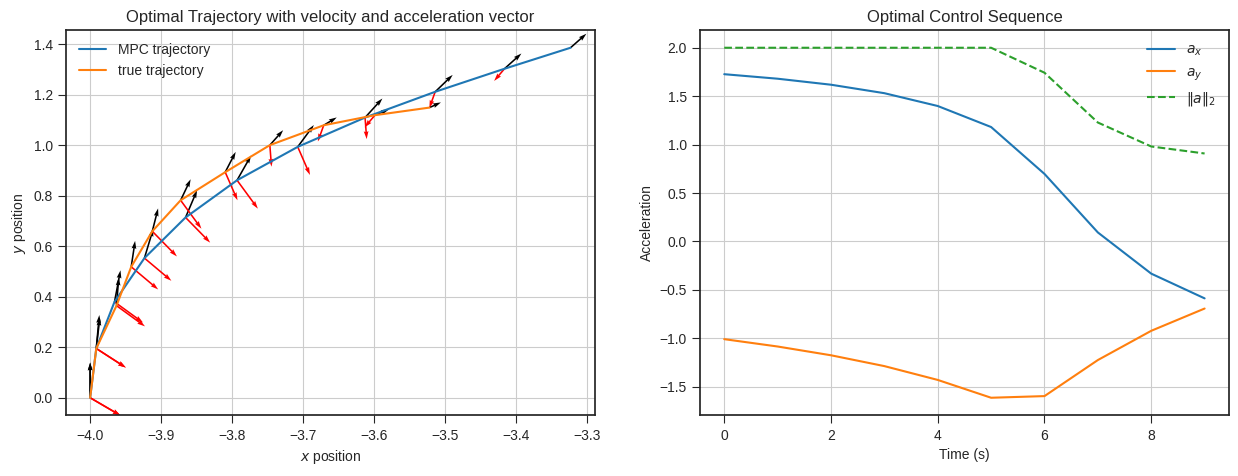

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(MPC_states[:,0], MPC_states[:,1], label="MPC trajectory")
plt.quiver(MPC_states[:,0], MPC_states[:,1], MPC_states[:,2], MPC_states[:,3], scale=30, width=.003)
plt.quiver(MPC_states[:-1,0], MPC_states[:-1,1], MPC_controls[:,0], MPC_controls[:,1], scale=30, width=.003, color='red')

plt.plot(true_states[:,0], true_states[:,1], label="true trajectory")
plt.quiver(true_states[:,0], true_states[:,1], true_states[:,2], true_states[:,3], scale=30, width=.003)
plt.quiver(true_states[:-1,0], true_states[:-1,1], MPC_controls[:,0], MPC_controls[:,1], scale=30, width=.003, color='red')
plt.title("Optimal Trajectory with velocity and acceleration vector")
plt.legend()
plt.xlabel("$x$ position")
plt.ylabel("$y$ position")
plt.grid()

plt.subplot(1,2,2)
plt.plot(MPC_controls)
plt.plot(np.linalg.norm(MPC_controls, 2, axis=1), '--')
plt.title("Optimal Control Sequence")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration")
plt.legend(["$a_x$", "$a_y$", "$\|a\|_2$"])
plt.grid()

## (b)

In [ ]:
# pre-defining the noise applied to the system
np.random.seed(seed=123) # play around with different seeds
noise_vec = np.random.randn(N_total_horizon, n) * np.array([0.0, 0.0, .1, .1])

In [ ]:
current_state = [initial_state]
problem = update_initial_state(setup_trajopt(A_dynamics, B_dynamics, Q, R, Qt, goal_state, u_max, N_MPC_horizon), current_state[0])
problem

Problem(Minimize(Expression(CONVEX, NONNEGATIVE, (1, 1))), [Equality(Expression(AFFINE, UNKNOWN, (4,)), Parameter((4,))), Equality(Expression(AFFINE, UNKNOWN, (4,)), Expression(AFFINE, UNKNOWN, (4,))), Inequality(Expression(CONVEX, NONNEGATIVE, ())), Equality(Expression(AFFINE, UNKNOWN, (4,)), Expression(AFFINE, UNKNOWN, (4,))), Inequality(Expression(CONVEX, NONNEGATIVE, ())), Equality(Expression(AFFINE, UNKNOWN, (4,)), Expression(AFFINE, UNKNOWN, (4,))), Inequality(Expression(CONVEX, NONNEGATIVE, ())), Equality(Expression(AFFINE, UNKNOWN, (4,)), Expression(AFFINE, UNKNOWN, (4,))), Inequality(Expression(CONVEX, NONNEGATIVE, ())), Equality(Expression(AFFINE, UNKNOWN, (4,)), Expression(AFFINE, UNKNOWN, (4,))), Inequality(Expression(CONVEX, NONNEGATIVE, ())), Equality(Expression(AFFINE, UNKNOWN, (4,)), Expression(AFFINE, UNKNOWN, (4,))), Inequality(Expression(CONVEX, NONNEGATIVE, ())), Equality(Expression(AFFINE, UNKNOWN, (4,)), Expression(AFFINE, UNKNOWN, (4,))), Inequality(Expression(CO

In [ ]:
# your MPC code
k = 0
MPC_states = [initial_state]
MPC_controls = []
N = N_total_horizon/N_MPC_horizon
while k < N_total_horizon:
    problem = update_initial_state(setup_trajopt(A_dynamics, B_dynamics, Q, R, Qt, goal_state, u_max, N_MPC_horizon), MPC_states[k])
    problem.solve()
    MPC_controls.append(problem.variables()[0].value[0])
    true_state = A_dynamics @ problem.variables()[1].value[0] + B_dynamics @ problem.variables()[0].value[0] + noise_vec[k]
    MPC_states.append(true_state)
    k += 1
OL_problem = update_initial_state(setup_trajopt(A_dynamics, B_dynamics, Q, R, Qt,
                                             goal_state, u_max, N_total_horizon),
                               initial_state)
OL_problem.solve()
MPC_states = np.array(MPC_states)  # size [time_horizon+1, n]
MPC_controls = np.array(MPC_controls)  # size [time_horizon, n]
OL_states = simulate_system(initial_state, OL_problem.variables()[0].value, noise_vec)  # size [time_horizon+1, n]
OL_controls = OL_problem.variables()[0].value  # size [time_horizon, n]

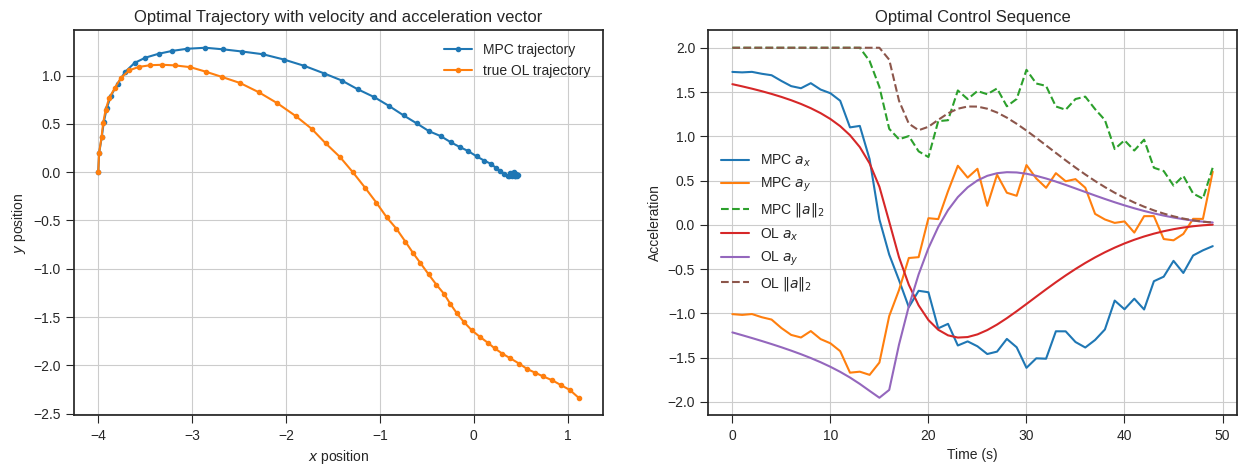

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(MPC_states[:,0], MPC_states[:,1], label="MPC trajectory", marker='.')
plt.plot(OL_states[:,0], OL_states[:,1], label="true OL trajectory", marker='.')

plt.title("Optimal Trajectory with velocity and acceleration vector")
plt.legend()
plt.xlabel("$x$ position")
plt.ylabel("$y$ position")
plt.grid()

plt.subplot(1,2,2)
plt.plot(MPC_controls)
plt.plot(np.linalg.norm(MPC_controls, 2, axis=1), '--')

plt.plot(OL_controls)
plt.plot(np.linalg.norm(OL_controls, 2, axis=1), '--')

plt.title("Optimal Control Sequence")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration")
plt.legend(["MPC $a_x$", "MPC $a_y$", "MPC $\|a\|_2$", "OL $a_x$", "OL $a_y$", "OL $\|a\|_2$"])
plt.grid()

# Problem 2 Kalman Filter

## (a)
Based on the given hints,
\
$$ Cov(X,W|Y) = \mathbb{E} \left[ (X - \mu_x) (W - \mu_w)^T | Y \right] $$
$$ = \int_w \int_x (x - \mu_x) (w - \mu_w)^T p(x,w|y) dx dw $$
\
$$ = \int_w \int_x (x - \mu_x)  p(x|y) p(w|y) dx dw $$
\
$$ = \int_w (w - \mu_w)^T \underbrace{p(w|y)}_{=p(w), w \perp y} dw \int_x (x - \mu_x) p(x|y) dx $$
\
$$ = \left[ \int_w w^T p(w) dw - \int_w \mu_w^T p(w) dw \right] \int_x (x - \mu_x) p(x|y) dx $$
\
$$ = \left[ \mu_w^T - \mu_w^T \underbrace{\int_w p(w) dw}_{=1} \right] \int_x (x - \mu_x) p(x|y) dx $$
\
$$ = 0 $$

## (b)
$$ \mathbb{E} \left[ (X_t - \mu_{t|t}) W_t^T | Y_{1:t} \right] =  \underbrace{\mathbb{E} \left[ X_t W_t^T | Y_{1:t} \right]}_A - \mathbb{E} \left[ \mu_{t|t} W_t^T | Y_{1:t} \right] $$
\
\
$$ A = Cov \left[ X_t W_t^T | Y_{1:t} \right] + \mathbb{E} \left[ X_t | Y_{1:t} \right] \mathbb{E} \left[ W_t^T | Y_{1:t} \right] $$
$$ = 0 + \mathbb{E} \left[ X_t | Y_{1:t} \right] \mathbb{E} \left[ W_t^T | Y_{1:t} \right] $$
$$ = \mathbb{E} \left[ X_t | Y_{1:t} \right] \mathbb{E} \left[ W_t^T | Y_{1:t} \right] $$
\
\
Rewrite the equation with A and $ \mu_{t|t} = \mathbb{E} \left[ X_t | Y_{1:t} \right] $:
\
\
$$ \mathbb{E} \left[ (X_t - \mu_{t|t}) W_t^T | Y_{1:t} \right] = \mathbb{E} \left[ X_t | Y_{1:t} \right] \mathbb{E} \left[ W_t^T | Y_{1:t} \right] - \mu_{t|t} \mathbb{E} \left[ W_t^T | Y_{1:t} \right] $$
\
\
$$ = \mathbb{E} \left[ X_t | Y_{1:t} \right] \mathbb{E} \left[ W_t^T | Y_{1:t} \right] - \mathbb{E} \left[ X_t | Y_{1:t} \right] \mathbb{E} \left[ W_t^T | Y_{1:t} \right] $$
$$ = 0 $$


## (c)
$$ X_{t+1} =
\begin{bmatrix}
1 & \delta t \\
0 & 1
\end{bmatrix}
X_t +
\begin{bmatrix}
0 \\
\delta t
\end{bmatrix}
u_t +
\begin{bmatrix}
0 & 0 \\
1 & 0
\end{bmatrix}
\begin{bmatrix}
W_t \\
V_t
\end{bmatrix}
$$

$$ Y_t =
\begin{bmatrix}
1 & 0
\end{bmatrix}
X_t +
\begin{bmatrix}
0 & 1
\end{bmatrix}
\begin{bmatrix}
W_t \\
V_t
\end{bmatrix}
$$

Hence,
$$ A =
\begin{bmatrix}
1 & \delta t \\
0 & 1
\end{bmatrix}
, \; B =
\begin{bmatrix}
0 \\
\delta t
\end{bmatrix}
, \; and \; C =
\begin{bmatrix}
1 & 0
\end{bmatrix}
$$

## (d)

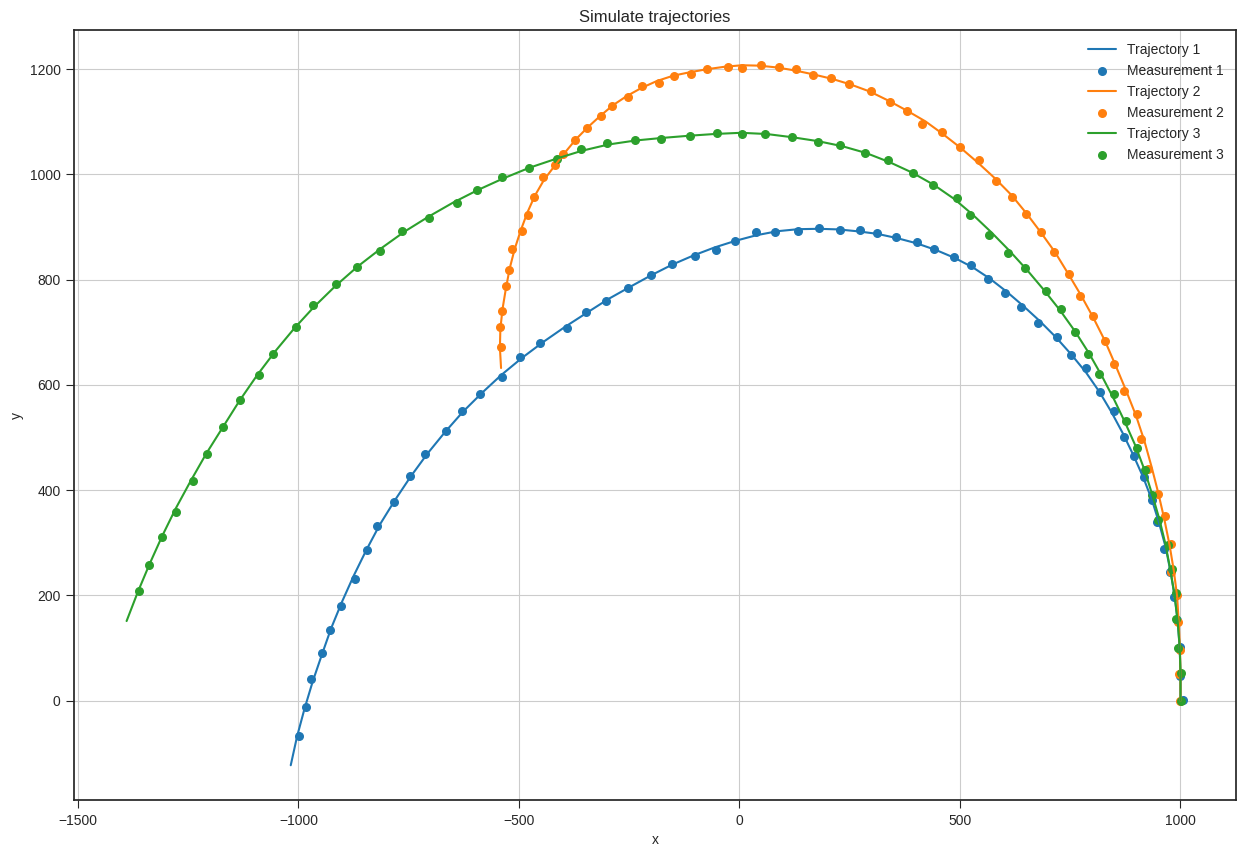

In [ ]:
# your code here. Make sure you label your plot clearly
# Recommend using plt.plot and plt.scatter to clearly show the state at each time step

T = 60
dt = 1
Q = np.eye(2)
R = np.eye(2)*9

# x = [x, y, v_x, v_y].T

A = np.array([[1., 0., dt, 0.],
              [0., 1., 0., dt],
              [0., 0., 1., 0.],
              [0., 0., 0., 1.]])
A = np.array([[1., 0., dt, 0.],
              [0., 1., 0., dt],
              [0., 0., 1., 0.],
              [0., 0., 0., 1.]])
B = np.array([[0., 0.],
              [0., 0.],
              [dt, 0.],
              [0., dt]])
C = np.array([[1., 0., 0., 0.],
              [0., 1., 0., 0.]])

p0 = np.array([1000., 0.])
s0 = np.array([0., 50.])
plt.figure(figsize=(15, 10))
N = 3
i = 0
while i < N:
  p = []
  p.append(p0)
  s = []
  s.append(s0)
  u = []
  gps = []
  for t in range(T):
    u.append(-2.5*np.array([np.cos(0.05*t), np.sin(0.05*t)]))
    W = np.sqrt(Q) @ np.random.randn(2)
    V = np.sqrt(R) @ np.random.randn(2)
    p_next = p[t] + dt*s[t]
    s_next = s[t] + dt*u[t] + W
    p.append(p_next)
    s.append(s_next)
    gps_next = p[t] + V
    gps.append(gps_next)

  P = np.array(p)
  S = np.array(s)
  U = np.array(u)
  GPS = np.array(gps)
  plt.plot(P[:, 0], P[:, 1], label='Trajectory ' + str(i+1))
  plt.scatter(GPS[:, 0], GPS[:, 1], label='Measurement ' + str(i+1), s=30)
  i += 1
plt.title("Simulate trajectories")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

## (e)
The mean of $ W_t^{new} $ is supposed to centered around the initial state $ (p0, s0) $:

$$ \mu^{new} = [1000, 0, 0, 50]^T $$

On the other hands, the new covariance only appears in the velocity equation, hence,

$$
Q^{new} =
\begin{bmatrix}
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
$$

## (f)

In [ ]:
# you may find these plotting functionalities useful. Or you can use your own code

def create_95_ellipse_patch(mean, covariance):
    chi_95 = 5.991
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]
    vals, vecs = eigsorted(covariance)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2  * np.sqrt(vals * chi_95)
    return Ellipse(xy=mean, width=w, height=h, angle=theta)


def plot_95_ellipse(mean, covariance, color):
    chi_95 = 5.991
    mean = np.array([[mean[0]],[mean[1]]])
    val, rot = np.linalg.eig(covariance)
    val = np.sqrt(val * chi_95)
    t = np.linspace(0, 2.0 * np.pi, 1000)
    xy = np.stack((np.cos(t), np.sin(t)), axis=-1)

    plt.plot(*(rot @ (val * xy).T + mean), color)
    plt.fill(*(rot @ (val * xy).T + mean), color, alpha=0.3)

<Figure size 1500x1000 with 0 Axes>

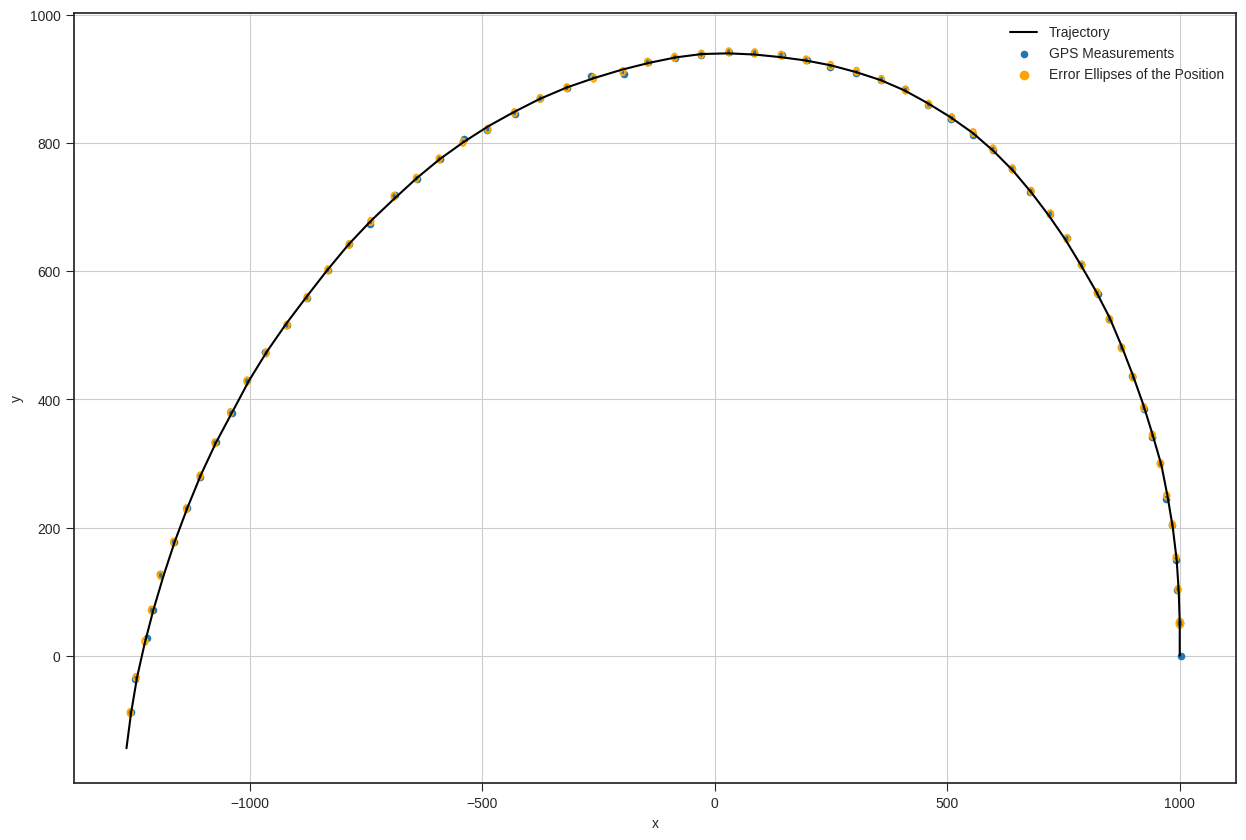

In [ ]:
# your code
plt.figure(figsize=(15, 10))
mean0 = np.array([1500, 100, 0, 55])
cov0 = np.block([[250000*np.eye(2), 0*np.eye(2)], [0*np.eye(2), np.eye(2)]])
plt.figure(figsize=(15, 10))
p0 = np.array([1000., 0.])
s0 = np.array([0., 50.])
p = []
p.append(p0)
s = []
s.append(s0)
u = []
gps = []
for t in range(T):
  u.append(-2.5*np.array([np.cos(0.05*t), np.sin(0.05*t)]))
  W = np.sqrt(Q) @ np.random.randn(2)
  V = np.sqrt(R) @ np.random.randn(2)
  p_next = p[t] + dt*s[t]
  s_next = s[t] + dt*u[t] + W
  p.append(p_next)
  s.append(s_next)
  gps_next = p[t] + V
  gps.append(gps_next)
P = np.array(p)
S = np.array(s)
U = np.array(u)
GPS = np.array(gps)
Qk = np.eye(4)
Rk = np.eye(2)*9
mean = []
mean.append(mean0)
cov = []
cov.append(cov0)
new_GPS = []
for t in range(1, T):
  predict_mean = A @ mean[t-1] + B @ u[t-1]
  predict_cov = A @ cov[t-1] @ A.T + Qk
  K = predict_cov @ C.T @ np.linalg.inv(C @ predict_cov @ C.T + Rk)
  update_mean = predict_mean + K @ (GPS[t] - C @ predict_mean)
  update_cov = (np.eye(4) - K @ C) @ predict_cov
  mean.append(update_mean)
  cov.append(update_cov)

  plot_95_ellipse(mean[t], cov[t][:2,:2], color='orange')

plt.plot(P[:, 0], P[:, 1], label='Trajectory', color='black')
plt.scatter(GPS[:, 0], GPS[:, 1], s=20, label='GPS Measurements')
plt.scatter([], [], color='orange', label='Error Ellipses of the Position')

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()


## (g)

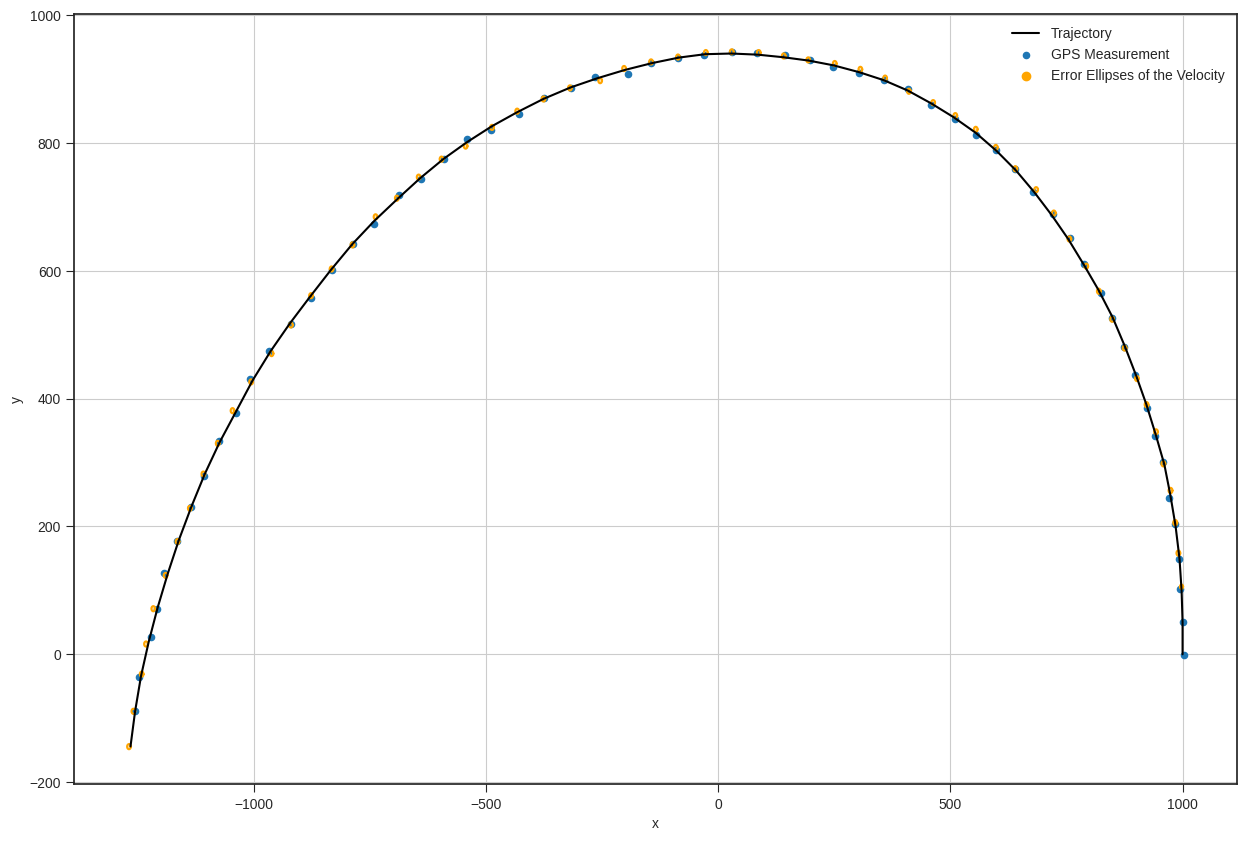

In [ ]:
# your code
plt.figure(figsize=(15, 10))
for t in range(1, T):

  plot_95_ellipse(mean[t][2:] + mean[t][:2], cov[t][2:,2:], color='orange')

plt.plot(P[:, 0], P[:, 1], label='Trajectory', color='black')
plt.scatter(GPS[:, 0], GPS[:, 1], s=20, label='GPS Measurement')
plt.scatter([], [], color='orange', label='Error Ellipses of the Velocity')

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

## (h)

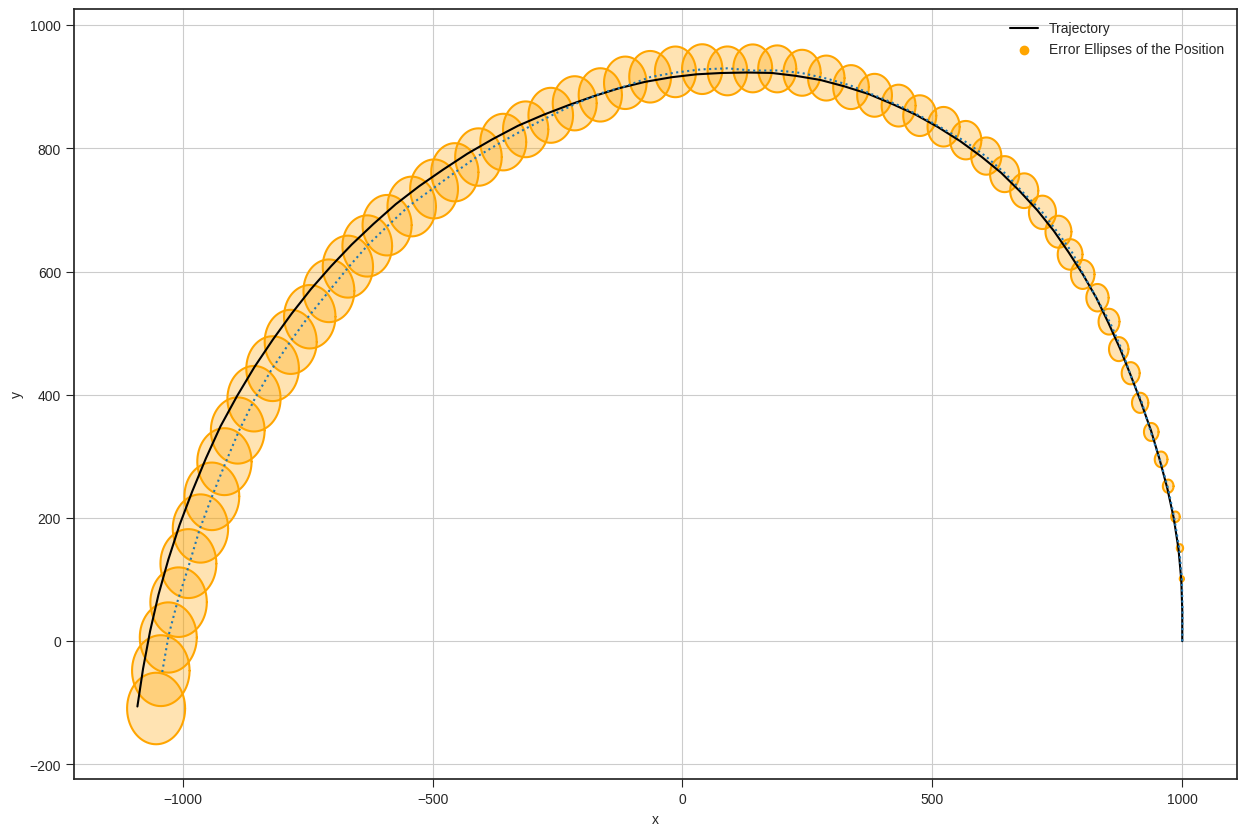

In [ ]:
# your code
plt.figure(figsize=(15, 10)) # for g specifically
mean0 = np.array([1000, 0, 0, 50]) # for g specifically
cov0 = np.diag((1, 1, 1, 1))

A = np.array([[1., 0., dt, 0.],
              [0., 1., 0., dt],
              [0., 0., 1., 0.],
              [0., 0., 0., 1.]])
A = np.array([[1., 0., dt, 0.],
              [0., 1., 0., dt],
              [0., 0., 1., 0.],
              [0., 0., 0., 1.]])
B = np.array([[0., 0.],
              [0., 0.],
              [dt, 0.],
              [0., dt]])
C = np.array([[0., 0., 1., 0.],
              [0., 0., 0., 1.]])

p0 = np.array([1000., 0.])
s0 = np.array([0., 50.])
p = []
p.append(p0)
s = []
s.append(s0)
u = []
gps = []
for t in range(T):
  u.append(-2.5*np.array([np.cos(0.05*t), np.sin(0.05*t)]))
  W = np.sqrt(Q) @ np.random.randn(2)
  V = np.sqrt(R) @ np.random.randn(2)
  p_next = p[t] + dt*s[t]
  s_next = s[t] + dt*u[t] + W
  p.append(p_next)
  s.append(s_next)
  gps_next = s[t] + V # for g specifically
  gps.append(gps_next)
P = np.array(p)
S = np.array(s)
U = np.array(u)
GPS = np.array(gps)
Qk = np.eye(4)
Rk = np.eye(2)*9
mean = []
mean.append(mean0)
cov = []
cov.append(cov0)
for t in range(1, T):
  predict_mean = A @ mean[t-1] + B @ u[t-1]
  predict_cov = A @ cov[t-1] @ A.T + Qk
  K = predict_cov @ C.T @ np.linalg.inv(C @ predict_cov @ C.T + Rk)
  update_mean = predict_mean + K @ (GPS[t] - C @ predict_mean)
  update_cov = (np.eye(4) - K @ C) @ predict_cov
  mean.append(update_mean)
  cov.append(update_cov)

  plot_95_ellipse(mean[t][:2] + mean[t][2:], cov[t][:2,:2], color='orange')
mean = np.array(mean)
plt.plot(P[:, 0], P[:, 1], label='Trajectory', color='black')
plt.scatter([], [], color='orange', label='Error Ellipses of the Position')
plt.plot(mean[:, 0], mean[:, 1], linestyle='dotted')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()